In [1]:
import xarray as xr # handling of large, labelled NetCDF time-series data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch  # PyTorch tensor library
import os
import torch.nn as nn # neural network modules (layers, loss functions)
import torch.nn.functional as F # functional interface for neural network operations
from torch.utils.data import Dataset, DataLoader # custom datasets and mini-batch loading

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight # to handle class imbalance
from sklearn.metrics import classification_report, confusion_matrix # evaluation metrics

In [2]:
SEED = 42  # fixed random seed to ensure reproducibility of results
BATCH_SIZE = 256
EPOCHS = 10 # number of full passes through the training dataset
LR = 1e-3 # learning rate for the optimizer (controls update step size)

In [3]:
WINDOW_IN_MIN = 180   # 3 hours window for input
WINDOW_OUT_MIN = 60   # 1 hour ahead for output

# map flare classes to an ordinal scale
# NOAA flare classes increase in severity from A to X

flare_order = {"A": 0, "B": 1, "C": 2, "M": 3, "X": 4}

def get_highest_class(classes):
    if len(classes) == 0:
        return "A"
    return max(classes, key=lambda c: flare_order[c]) # return the most severe class, if no flares occur, default to 'A'

def make_future_labels(index, flare_df, horizon_min=60): # create a label for each timestamp in the irradiance time index
    fl_times = flare_df['flare_time'].values
    fl_classes = flare_df['class_letter'].values
    n_events = len(fl_times)
    labels = []
    j = 0

    for t in index.values:
        # advance pointer past any flares before t
        # only consider flares in the future horizon
        while j < n_events and fl_times[j] < t: 
            j += 1
        # define horizon end time: t + horizon_min minutes
        h_end = t + np.timedelta64(horizon_min, 'm') # assign the label as the most severe flare that occurs in [t, t + horizon]
        k = j
        classes = []

        while k < n_events and fl_times[k] <= h_end: # collect all flare classes that occur within the forecast window
            classes.append(fl_classes[k])
            k += 1

        labels.append(get_highest_class(classes)) # assign the most severe class in the horizon, else default to 'A'

    return np.array(labels)

def build_windows(irrad_1m, labels, window_in_min=180): # convert the continuous 1-minute irradiance series into supervised learning samples
    data = irrad_1m[['short_xray', 'long_xray']].values # select the two GOES XRS channels as model inputs
    X_list, y_list = [], []

    for i in range(window_in_min, len(irrad_1m)):
        x_window = data[i-window_in_min:i, :]
        X_list.append(x_window) # input: previous window (timestamp)
        y_list.append(labels[i]) # target: class label aligned to the current timestamp i

    X = np.stack(X_list)
    y = np.array(y_list)
    return X, y

In [4]:
def process_year(year, base_irrad_dir="", base_flsum_dir=""): # load and preprocess one year of GOES data and generate supervised learning samples
    print(f"\n=== Processing year {year} ===")
    irrad_path = f"{base_irrad_dir}irrad_{year}.nc"
    flsum_path = f"{base_flsum_dir}flsum_{year}.nc"

    # load irrad
    irrad_ds = xr.open_dataset(irrad_path)
    irrad_df = irrad_ds[['a_flux', 'b_flux']].to_dataframe().reset_index()

    irrad_df.rename(columns={ # short_xray = 0.05–0.4 nm, long_xray = 0.1–0.8 nm (GOES XRS channels)
        'time': 'timestamp',
        'a_flux': 'short_xray',
        'b_flux': 'long_xray'
    }, inplace=True)

    irrad_df['timestamp'] = pd.to_datetime(irrad_df['timestamp'])
    irrad_df.set_index('timestamp', inplace=True)

    # resample to 1-min
    irrad_1m = irrad_df.resample('1min').mean().dropna() # dropna removes missing segments
    print("1-min irradiance shape:", irrad_1m.shape)

    # load flare summary
    flsum_ds = xr.open_dataset(flsum_path)
    flsum_df = flsum_ds[['flare_class']].to_dataframe().reset_index()

    flsum_df.rename(columns={'time': 'flare_time'}, inplace=True)
    flsum_df['flare_time'] = pd.to_datetime(flsum_df['flare_time'])
    flsum_df['class_letter'] = flsum_df['flare_class'].astype(str).str[0]

    valid_classes = ['A', 'B', 'C', 'M', 'X'] # only valid NOAA flare classes and sort chronologically
    flsum_df = flsum_df[flsum_df['class_letter'].isin(valid_classes)].copy()
    flsum_df.sort_values('flare_time', inplace=True)
    flsum_df.reset_index(drop=True, inplace=True)

    print("Number of flare events:", len(flsum_df))

    # future labels (next 1 hour)
    labels = make_future_labels(irrad_1m.index, flsum_df, horizon_min=WINDOW_OUT_MIN)
    print("Labels shape:", labels.shape)

    # build sliding windows
    X_year, y_year = build_windows(irrad_1m, labels, window_in_min=WINDOW_IN_MIN)
    print("Year", year, "X shape:", X_year.shape, "y shape:", y_year.shape)

    return X_year, y_year

In [5]:
base_irrad_dir = "C:/Users/ruthw/Desktop/irrad/"
base_flsum_dir = "C:/Users/ruthw/Desktop/flsum/"

In [6]:
YEARS = [2015, 2016, 2017]  # adjust based on data availability

X_list = []
y_list = []

for year in YEARS:
    X_y, y_y = process_year(year, base_irrad_dir, base_flsum_dir)
    X_list.append(X_y)
    y_list.append(y_y)

X_all = np.concatenate(X_list, axis=0) # unified multi-year dataset
y_all = np.concatenate(y_list, axis=0)

print("Combined X:", X_all.shape)
print("Combined y:", y_all.shape)
print(pd.Series(y_all).value_counts())


=== Processing year 2015 ===
1-min irradiance shape: (498420, 2)
Number of flare events: 2822
Labels shape: (498420,)
Year 2015 X shape: (498240, 180, 2) y shape: (498240,)

=== Processing year 2016 ===
1-min irradiance shape: (501754, 2)
Number of flare events: 2084
Labels shape: (501754,)
Year 2016 X shape: (501574, 180, 2) y shape: (501574,)

=== Processing year 2017 ===
1-min irradiance shape: (497854, 2)
Number of flare events: 1541
Labels shape: (497854,)
Year 2017 X shape: (497674, 180, 2) y shape: (497674,)
Combined X: (1497488, 180, 2)
Combined y: (1497488,)
A    1182164
B     160989
C     138797
M      14842
X        696
Name: count, dtype: int64


In [7]:
X_all[~np.isfinite(X_all)] = 0.0 # clean
X_all = np.clip(X_all, 0.0, None)

X_all = np.log10(X_all + 1e-10) # log-transform

mean = X_all.mean(axis=(0, 1), keepdims=True) # global standardization
std  = X_all.std(axis=(0, 1), keepdims=True) + 1e-6
X_all = (X_all - mean) / std

print("After transform, any NaN?", np.isnan(X_all).any(), " any Inf?", np.isinf(X_all).any()) # sanity checks

After transform, any NaN? False  any Inf? False


In [8]:
np.save("X_multi.npy", X_all)
np.save("y_multi.npy", y_all)

In [9]:
X = np.load("X_multi.npy")
y = np.load("y_multi.npy")

# manual encoding to keep class order fixed across runs and models
label_map = {'A': 0, 'B': 1, 'C': 2, 'M': 3, 'X': 4}
y_encoded = np.array([label_map[c] for c in y])
inv_label_map = {v: k for k, v in label_map.items()} # decoding predictions back to flare class letters during reporting

# 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded # stratification is essential due to severe class imbalance
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

classes = np.array([0,1,2,3,4]) # balanced weighting assigns higher weights to rarer classes, allows the models to pay further attention to rarer classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32) # convert weights to a PyTorch tensor for use in weighted losses
print("Class weights:", class_weights)

Class weights: tensor([2.5335e-01, 1.8604e+00, 2.1578e+00, 2.0178e+01, 4.3049e+02])


# MODELS

In [10]:
print("X:", X.shape)
print("y:", y.shape)
pd.Series(y).value_counts()

X: (1497488, 180, 2)
y: (1497488,)


A    1182164
B     160989
C     138797
M      14842
X        696
Name: count, dtype: int64

In [11]:
label_map = {'A': 0, 'B': 1, 'C': 2, 'M': 3, 'X': 4}
inv_label_map = {v: k for k, v in label_map.items()}

y_encoded = np.array([label_map[c] for c in y]) # encode string labels into integer form required by ML models

In [12]:
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1048241, 180, 2) Val: (224623, 180, 2) Test: (224624, 180, 2)


In [13]:
classes = np.array([0,1,2,3,4])
# compute standard "balanced" class weights based on inverse class frequency
raw_weights = compute_class_weight( # assigns very large weights to rare classes (especially X-class flares)
    class_weight='balanced',
    classes=classes,
    y=y_train
)

# tame extreme imbalance
scaled_weights = np.sqrt(raw_weights) # apply square-root scaling to compress the weight range
scaled_weights = scaled_weights / scaled_weights.min() # normalise weights so the smallest class weight is 1.0

class_weights = torch.tensor(scaled_weights, dtype=torch.float32)

print("Raw:", raw_weights)
print("Scaled:", scaled_weights)

Raw: [2.53347013e-01 1.86036453e+00 2.15780687e+00 2.01778826e+01
 4.30489117e+02]
Scaled: [ 1.          2.70982429  2.91842402  8.92441795 41.22144335]


In [14]:
class GOESDataset(Dataset):
    def __init__(self, X, y): # convert inputs to PyTorch-compatible data types
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64) # int64 is required for classification targets in PyTorch

    def __len__(self):
        return len(self.X) # return the total number of samples

    def __getitem__(self, idx):
        # (180, 2) → (2, 180)
        x = self.X[idx].transpose(1, 0) # layout is required for 1D convolutional layers
        return x, self.y[idx]

train_loader = DataLoader(GOESDataset(X_train, y_train), batch_size=256, shuffle=True)
# shuffle=True to randomise batches and improve generalisation
# smaller batch size to balance GPU memory usage and gradient stability
val_loader   = DataLoader(GOESDataset(X_val, y_val), batch_size=512, shuffle=False)
# shuffle=False to ensure deterministic evaluation
# larger batch size since gradients are not computed
test_loader  = DataLoader(GOESDataset(X_test, y_test), batch_size=512, shuffle=False) #identical setup to validation for fair, repeatable performance reporting

# CNN

In [15]:
class CNN1D(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=5, padding=2)  # expands feature representation from 2 input channels to 32 filters
        self.bn1   = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2) # learns higher-level temporal features
        self.bn2   = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2) # further increases representational capacity
        self.bn3   = nn.BatchNorm1d(128)

        self.pool = nn.MaxPool1d(2) # reduces sequence length and provides local translation invariance
        self.dropout = nn.Dropout(0.3) # dropout regularisation to reduce overfitting

        self.global_pool = nn.AdaptiveAvgPool1d(1) # enforces temporal invariance and reduces parameter count
        self.fc = nn.Linear(128, n_classes) # final fully connected layer maps features to flare classes

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x)))) # convolution → batch norm → ReLU → pooling
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x).squeeze(-1) # aggregate temporal features using global average pooling
        x = self.dropout(x) # apply dropout during training
        return self.fc(x)

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.0):
        super().__init__()
        self.alpha = alpha # alpha : torch.Tensor or None, class weighting factor to further compensate for class imbalance
        self.gamma = gamma # focusing parameter that controls how strongly easy examples are down-weighted

    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none') # compute standard cross-entropy loss per sample (no reduction)
        pt = torch.exp(-ce) # pt = exp(-CE) corresponds to the model confidence
        loss = ((1 - pt) ** self.gamma) * ce # (1 - pt)^gamma reduces the contribution of easy samples
        return loss.mean()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # CUDA for faster training

model = CNN1D(n_classes=5).to(device) # instantiate the CNN model for 5-class flare classification
criterion = FocalLoss(alpha=class_weights.to(device), gamma=1.0) # gamma controls how strongly easy examples are down-weighted
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer is a stable default for deep learning on time-series data

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    # switch model behaviour:
    # - train(): enables dropout and batch norm updates
    # - eval(): disables dropout and uses running stats for batch norm

    total_loss, correct, total = 0, 0, 0

    for Xb, yb in loader: # iterate over mini-batches
        Xb, yb = Xb.to(device), yb.to(device)
        if train:
            optimizer.zero_grad() # reset gradients before each optimisation step (training only)

        with torch.set_grad_enabled(train): # enable/disable gradient tracking depending on train/eval mode
            out = model(Xb) # forward pass (logits)
            loss = criterion(out, yb) # compute loss against ground-truth labels
            if train: # backpropagation and parameter update (training only)
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * len(yb)
        preds = out.argmax(1) # convert logits to predicted class indices
        correct += (preds == yb).sum().item() # correct predictions for accuracy
        total += len(yb)

    return total_loss / total, correct / total

In [18]:
for ep in range(1, EPOCHS+1):
    train_loss, train_acc = run_epoch(train_loader, train=True) # run one training epoch (weights updated)
    val_loss, val_acc     = run_epoch(val_loader, train=False) # run one validation epoch (no weight updates)

    print(f"Epoch {ep:02d} | "
          f"Train loss {train_loss:.4f}, acc {train_acc:.3f} | "
          f"Val loss {val_loss:.4f}, acc {val_acc:.3f}")

Epoch 01 | Train loss 1.0090, acc 0.691 | Val loss 0.9767, acc 0.673
Epoch 02 | Train loss 0.9634, acc 0.708 | Val loss 0.9641, acc 0.739
Epoch 03 | Train loss 0.9376, acc 0.713 | Val loss 0.9742, acc 0.677
Epoch 04 | Train loss 0.9177, acc 0.717 | Val loss 0.9541, acc 0.568
Epoch 05 | Train loss 0.8977, acc 0.720 | Val loss 0.9886, acc 0.688
Epoch 06 | Train loss 0.8775, acc 0.723 | Val loss 0.8722, acc 0.744
Epoch 07 | Train loss 0.8597, acc 0.725 | Val loss 0.9443, acc 0.501
Epoch 08 | Train loss 0.8392, acc 0.728 | Val loss 0.8301, acc 0.719
Epoch 09 | Train loss 0.8225, acc 0.730 | Val loss 1.1866, acc 0.748
Epoch 10 | Train loss 0.8071, acc 0.732 | Val loss 0.8449, acc 0.763


In [19]:
model.eval()
all_preds, all_true = [], []

with torch.no_grad(): # disable gradient computation for efficiency and correctness during evaluation
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = model(Xb)
        preds = out.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

print(classification_report(all_true, all_preds,
                            target_names=['A','B','C','M','X']))

              precision    recall  f1-score   support

           A       0.87      0.85      0.86    177325
           B       0.48      0.21      0.30     24149
           C       0.39      0.66      0.49     20820
           M       0.27      0.48      0.34      2226
           X       0.29      0.88      0.43       104

    accuracy                           0.76    224624
   macro avg       0.46      0.62      0.48    224624
weighted avg       0.78      0.76      0.76    224624



Counts:
        A     B      C     M    X
A  151414  4885  18904  1989  133
B   17272  5160   1713     4    0
C    5362   598  13793   980   87
M     195    21    921  1079   10
X       0     1      7     4   92


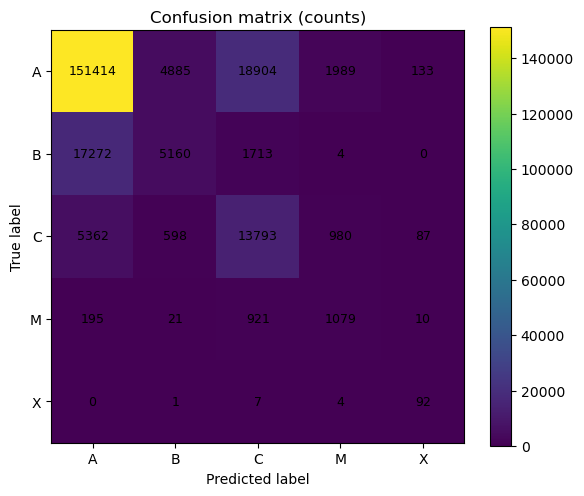

In [20]:
labels = ['A','B','C','M','X']
cm_CNN = confusion_matrix(all_true, all_preds)

print("Counts:")
print(pd.DataFrame(cm_CNN, index=labels, columns=labels))
title = "Confusion matrix (counts)"
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_CNN)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(title)

# annotate cells
for i in range(len(labels)):
    for j in range(len(labels)):
        val = cm_CNN[i, j]
        if isinstance(val, (float, np.floating)):
            text = f"{val:.2f}"
        else:
            text = str(int(val))
        ax.text(j, i, text, ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [21]:
# Ground truth: C-class or lower
y_true_C = (all_true >= 2).astype(int)
y_pred_C = (all_preds >= 2).astype(int)

print("Binary C-class or lower classification report:")
print(classification_report(
    y_true_C,
    y_pred_C,
    target_names=["<C (A/B)", "≥C (C/M/X)"]
))

print("Confusion matrix (C-class or lower):")
print(confusion_matrix(y_true_C, y_pred_C))

Binary C-class or lower classification report:
              precision    recall  f1-score   support

    <C (A/B)       0.97      0.89      0.93    201474
  ≥C (C/M/X)       0.43      0.73      0.54     23150

    accuracy                           0.87    224624
   macro avg       0.70      0.81      0.73    224624
weighted avg       0.91      0.87      0.89    224624

Confusion matrix (C-class or lower):
[[178731  22743]
 [  6177  16973]]


In [22]:
# Ground truth: M-class or higher
y_true_M = (all_true >= 3).astype(int)
y_pred_M = (all_preds >= 3).astype(int)

print("Binary M-class or higher classification report:")
print(classification_report(
    y_true_M,
    y_pred_M,
    target_names=["<M (A/B/C)", "≥M (M/X)"]
))

print("Confusion matrix (M-class or higher):")
print(confusion_matrix(y_true_M, y_pred_M))

Binary M-class or higher classification report:
              precision    recall  f1-score   support

  <M (A/B/C)       0.99      0.99      0.99    222294
    ≥M (M/X)       0.27      0.51      0.35      2330

    accuracy                           0.98    224624
   macro avg       0.63      0.75      0.67    224624
weighted avg       0.99      0.98      0.98    224624

Confusion matrix (M-class or higher):
[[219101   3193]
 [  1145   1185]]


In [23]:
class SeqDataset(Dataset):
    def __init__(self, X, y): # convert inputs to PyTorch-compatible data types
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self): 
        return len(self.X) # return the total number of samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # return a single time-series sequence and its label

train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(SeqDataset(X_val, y_val), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)
test_loader  = DataLoader(SeqDataset(X_test, y_test), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.0):
        super().__init__()
        self.alpha = alpha # class weighting factor
        self.gamma = gamma # focusing parameter

    def forward(self, logits, targets): 
        ce = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none') # compute per-sample cross-entropy loss (no reduction)
        pt = torch.exp(-ce) # convert loss to predicted probability of the true class
        return (((1 - pt) ** self.gamma) * ce).mean() # focal modulation to emphasise hard-to-classify samples

# RNN

In [24]:
class RNN(nn.Module):
# this model processes the irradiance time series sequentially and uses the final hidden state as a compact summary of the input window.
# it serves as a baseline recurrent architecture for comparison against more advanced gated models (LSTM and GRU).
    def __init__(self, hidden=64):
        super().__init__()
        # recurrent layer:
        # - input_size = 2 (short_xray and long_xray channels)
        # - hidden_size controls the dimensionality of the learned temporal representation
        # - batch_first=True expects input shape (batch, time, features)
        self.rnn = nn.RNN(2, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 5) # fully connected layer mapping final hidden state to flare classes
 
    def forward(self, x):
        # RNN returns:
        # - output: hidden states for all time steps (unused here)
        # - h: final hidden state for each layer
        _, h = self.rnn(x)
        return self.fc(h[-1])

# LSTM

In [25]:
class LSTM(nn.Module):
# LSTMs extend simple RNNs by incorporating gating mechanisms that regulate information flow, enabling more effective
# modelling of long-range temporal dependencies in time-series data.
    def __init__(self, hidden=96):
        super().__init__()
        # LSTM layer:
        # - input_size = 2 (short_xray and long_xray channels)
        # - hidden_size controls the dimensionality of the internal memory
        # - batch_first=True expects input shape (batch, time, features)
        self.lstm = nn.LSTM(2, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 5)

    def forward(self, x):
        # LSTM returns:
        # - output: hidden states for all time steps (unused here)
        # - (h, c): final hidden state and cell state
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

# GRU

In [26]:
class GRU(nn.Module):
# GRUs are a simplified alternative to LSTMs that retain gating mechanisms while reducing architectural complexity. Offers a favourable
# trade-off between modelling capacity and computational efficiency.
    def __init__(self, hidden=96):
        super().__init__()
        # GRU layer:
        # - input_size = 2 (short_xray and long_xray channels)
        # - hidden_size controls the dimensionality of the learned representation
        # - batch_first=True expects input shape (batch, time, features)
        self.gru = nn.GRU(2, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 5)

    def forward(self, x):
        # GRU returns:
        # - output: hidden states for all time steps (unused here)
        # - h: final hidden state for each layer
        _, h = self.gru(x)
        return self.fc(h[-1])

In [31]:
def train_and_eval(model, name):
    model = model.to(device)
    criterion = FocalLoss(alpha=class_weights.to(device), gamma=1.0) # focal loss with class weights to address severe class imbalance
    optimizer = torch.optim.Adam(model.parameters(), lr=LR) # Adam optimiser is a stable default for neural time-series models

    for ep in range(1, EPOCHS + 1):
        model.train()
        train_loss_sum, train_correct, train_total = 0.0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            out = model(xb) # logits: (batch, n_classes)
            loss = criterion(out, yb) # scalar loss
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * len(yb)
            preds = out.argmax(1)
            train_correct += (preds == yb).sum().item()
            train_total += len(yb)

        train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total

        # validation
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)

                out = model(xb)                 # recompute logits
                loss = criterion(out, yb)       

                val_loss_sum += loss.item() * len(yb)
                preds = out.argmax(1)
                val_correct += (preds == yb).sum().item()
                val_total += len(yb)

        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total

        print(
            f"{name} | Epoch {ep:02d} | "
            f"Train loss {train_loss:.4f}, acc {train_acc:.3f} | "
            f"Val loss {val_loss:.4f}, acc {val_acc:.3f}"
        )

    # test
    model.eval()
    all_p, all_t = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            all_p.append(out.argmax(1).cpu().numpy())
            all_t.append(yb.numpy())

    all_p = np.concatenate(all_p)
    all_t = np.concatenate(all_t)

    CLASSES = ['A', 'B', 'C', 'M', 'X']

    print(f"\n{name} CLASSIFICATION REPORT\n")
    print(classification_report(all_t, all_p, target_names=CLASSES))

    cm = confusion_matrix(all_t, all_p)
    print(f"\nConfusion matrix for {name} (counts):\n")
    print(pd.DataFrame(cm, index=CLASSES, columns=CLASSES))

    title = "Confusion matrix (counts)"
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm)
    
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            val = cm[i, j]
            if isinstance(val, (float, np.floating)):
                text = f"{val:.2f}"
            else:
                text = str(int(val))
            ax.text(j, i, text, ha="center", va="center", fontsize=9)
    
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    return all_t, all_p


RNN | Epoch 01 | Train loss 1.1073, acc 0.685 | Val loss 1.0375, acc 0.606
RNN | Epoch 02 | Train loss 1.0647, acc 0.665 | Val loss 1.0405, acc 0.694
RNN | Epoch 03 | Train loss 1.0469, acc 0.656 | Val loss 1.0411, acc 0.586
RNN | Epoch 04 | Train loss 1.0410, acc 0.657 | Val loss 1.2411, acc 0.666
RNN | Epoch 05 | Train loss 1.0390, acc 0.655 | Val loss 1.0263, acc 0.662
RNN | Epoch 06 | Train loss 1.0598, acc 0.674 | Val loss 1.0346, acc 0.645
RNN | Epoch 07 | Train loss 1.0378, acc 0.658 | Val loss 1.0307, acc 0.744
RNN | Epoch 08 | Train loss 1.0320, acc 0.658 | Val loss 1.0195, acc 0.599
RNN | Epoch 09 | Train loss 1.0270, acc 0.657 | Val loss 1.0170, acc 0.531
RNN | Epoch 10 | Train loss 1.0328, acc 0.655 | Val loss 1.0200, acc 0.593

RNN CLASSIFICATION REPORT

              precision    recall  f1-score   support

           A       0.87      0.60      0.71    177325
           B       0.22      0.50      0.31     24149
           C       0.31      0.67      0.43     20820
     

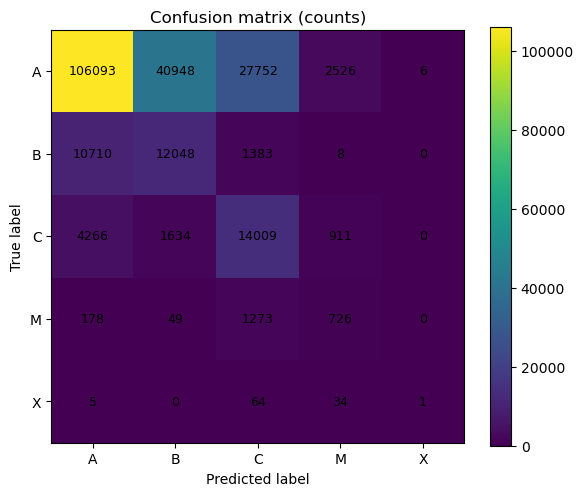

(array([0, 0, 2, ..., 0, 2, 0]), array([2, 2, 2, ..., 0, 0, 2]))

In [32]:
rnn = RNN(hidden=64)
train_and_eval(rnn, "RNN")

LSTM | Epoch 01 | Train loss 1.0952, acc 0.689 | Val loss 1.0388, acc 0.612
LSTM | Epoch 02 | Train loss 1.0419, acc 0.665 | Val loss 1.0158, acc 0.669
LSTM | Epoch 03 | Train loss 1.0264, acc 0.667 | Val loss 1.0109, acc 0.715
LSTM | Epoch 04 | Train loss 1.0155, acc 0.674 | Val loss 1.0080, acc 0.703
LSTM | Epoch 05 | Train loss 1.0001, acc 0.673 | Val loss 0.9870, acc 0.668
LSTM | Epoch 06 | Train loss 0.9679, acc 0.695 | Val loss 0.9404, acc 0.666
LSTM | Epoch 07 | Train loss 0.9488, acc 0.702 | Val loss 0.9641, acc 0.689
LSTM | Epoch 08 | Train loss 0.9441, acc 0.706 | Val loss 1.1265, acc 0.764
LSTM | Epoch 09 | Train loss 1.0362, acc 0.670 | Val loss 1.0036, acc 0.602
LSTM | Epoch 10 | Train loss 1.0052, acc 0.652 | Val loss 0.9932, acc 0.746

LSTM CLASSIFICATION REPORT

              precision    recall  f1-score   support

           A       0.83      0.87      0.85    177325
           B       0.45      0.04      0.07     24149
           C       0.35      0.58      0.44     

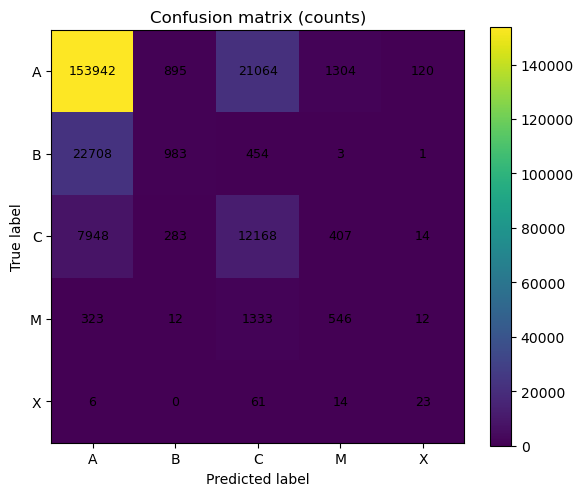

(array([0, 0, 2, ..., 0, 2, 0]), array([2, 2, 2, ..., 0, 0, 2]))

In [33]:
lstm = LSTM(hidden=96)
train_and_eval(lstm, "LSTM")

GRU | Epoch 01 | Train loss 1.0723, acc 0.677 | Val loss 1.0082, acc 0.687
GRU | Epoch 02 | Train loss 0.9999, acc 0.677 | Val loss 0.9680, acc 0.726
GRU | Epoch 03 | Train loss 0.9552, acc 0.696 | Val loss 0.9471, acc 0.675
GRU | Epoch 04 | Train loss 0.9341, acc 0.700 | Val loss 0.9207, acc 0.728
GRU | Epoch 05 | Train loss 0.9211, acc 0.703 | Val loss 0.9322, acc 0.685
GRU | Epoch 06 | Train loss 0.9105, acc 0.704 | Val loss 0.9012, acc 0.713
GRU | Epoch 07 | Train loss 0.9032, acc 0.705 | Val loss 0.8865, acc 0.675
GRU | Epoch 08 | Train loss 0.8961, acc 0.707 | Val loss 0.8812, acc 0.699
GRU | Epoch 09 | Train loss 0.8883, acc 0.708 | Val loss 0.9027, acc 0.696
GRU | Epoch 10 | Train loss 0.8877, acc 0.707 | Val loss 0.8769, acc 0.692

GRU CLASSIFICATION REPORT

              precision    recall  f1-score   support

           A       0.90      0.73      0.80    177325
           B       0.32      0.49      0.39     24149
           C       0.35      0.65      0.45     20820
     

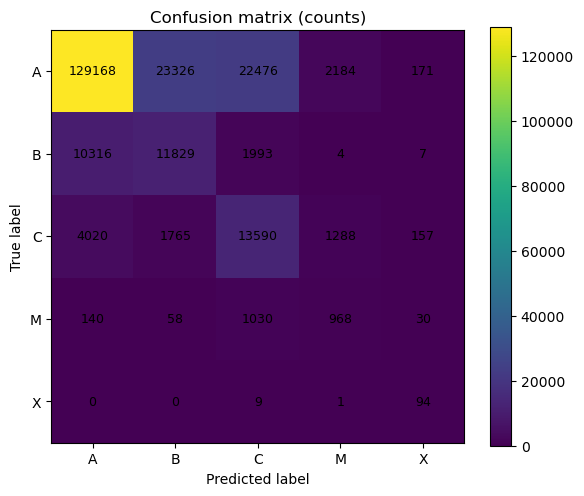

(array([0, 0, 2, ..., 0, 2, 0]), array([2, 2, 2, ..., 0, 2, 2]))

In [34]:
gru = GRU(hidden=69)
train_and_eval(gru, "GRU")